# Tech Challenge - Fase 4

**Faculdade de Informática de Administração Paulista – FIAP**

---

*Pos Tech em Data Analytics*

Turma 7DTAT

Alunos:

* Caroline Yuri Noguti - RM 358779
* Rafael Nascimento Coutinho – RM 358930

Data: 12/05/2025

Notebook para análise dos dados com criação e avaliação do modelo

*Análise do valor do petróleo Brent*

## **2. Bibliotecas**

Bibliotecas que serão utilizados

In [75]:
# Bibliotecas para manipulação de datas, dataframe de array e matrizes
import pandas as pd
import numpy as np

# Bibliotecas para gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Bibliotecas para decomposiçoes de série temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Bibliotecas para requisições em API e manupulação de JSON
import requests
import json

# Bibliotecas de transformadores personalizados para criação de pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Bibliotecas de machine learning
from xgboost import XGBRegressor
!pip install prophet
from prophet import Prophet
import lightgbm as lgb

# Bibliotecas para validação do modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Biblioteca para extrair o modelo treinado para o Streamlit
import joblib

# Biblioteca para remover os alertas
import warnings
warnings.filterwarnings("ignore")


# DESCONSIDERAR
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import TimeSeriesSplit
# from imblearn.over_sampling import SMOTE
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder

## **3. Carregando bases de dados**

### **3.1. Petróleo Brent (IPEA)**

Carregando os dados pelo site do IPEA

In [3]:
# URL quem tem a base de dados com os valores do petróleo Brent
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

df_ipea_brent = pd.read_html(url
                             ,encoding='utf-8' # Codificação de caracteres da página
                             ,attrs={'id':'grd_DXMainTable'} # Filtrando o conteúdo da página pelo id da tabela no HTML
                             ,thousands= '.' # Usei o separador de milhar para carregar com a virgula
                             ,skiprows=1 # Removendo a primeira linha pois eu vou passar os nomes das colunas
                             )[0] # Essa função retorna uma lista de tabelas e informo que somente quero a primeira

Tratamento de dados inicial, ajustando nome colunas, valores nulos, duplicados e tipagem das colunas

In [4]:
df_ipea_brent.columns = ['data', 'valor']
display(df_ipea_brent.head(2))
display(df_ipea_brent.tail(2))
print(f'Tamanho do dataframe: {df_ipea_brent.shape}')

,data,valor
0,02/05/2025,"61,57"
1,01/05/2025,"62,37"


,data,valor
11413,21/05/1987,"18,45"
11414,20/05/1987,"18,63"


Tamanho do dataframe: (11415, 2)


In [5]:
print('Registros nulos')
df_ipea_brent.isnull().sum()

Registros nulos


,0
data,0
valor,0


In [6]:
print(f'Registros duplicados: {df_ipea_brent.duplicated().sum()}')

Registros duplicados: 0


In [7]:
df_ipea_brent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11415 entries, 0 to 11414
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    11415 non-null  object
 1   valor   11415 non-null  object
dtypes: object(2)
memory usage: 178.5+ KB


In [8]:
df_ipea_brent['data'] = pd.to_datetime(df_ipea_brent['data'] , format="%d/%m/%Y")
df_ipea_brent['valor'] = df_ipea_brent['valor'].str.replace(',','.')
df_ipea_brent['valor'] = df_ipea_brent['valor'].astype(float)
df_ipea_brent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11415 entries, 0 to 11414
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    11415 non-null  datetime64[ns]
 1   valor   11415 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 178.5 KB


In [9]:
df_ipea_brent = df_ipea_brent.set_index('data')
df_ipea_brent = df_ipea_brent.sort_index(ascending=True)
df_ipea_brent.head()

,valor
data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


Resultado final um df com a data e o valor do petróleo Brent

### **3.2. Produção Mundial de Petróleo (EIA)**

EIA: Agência do Sistema Estatístico Federal dos EUA responsável por coletar, analisar e disseminar informações sobre energia.

A IPEA usa essa base para pegar o valor do petróleo Brent, vamos usar para trazer a produção de petróleo

Conectado na API e baixando os dados para um dataframe

In [10]:
# API para baixar os dados do EIA: https://www.eia.gov/opendata/browser/international

# Variável com URL da API
url = 'https://api.eia.gov/v2/international/data/'

# Dicionário com os parâmetros da API
parametros = {
     'frequency': 'monthly'
    ,'data[0]': 'value'
    ,'start': '1987-01'
    ,'end': '2024-12'
    ,'sort[0][column]': 'period'
    ,'sort[0][direction]': 'desc'
    ,'facets[productId][]': '57'
    ,'facets[countryRegionId][]': ''
    ,'offset': 0
    ,'length': 4999 # A API somente permite pegar 5000 registros em uma requisição, por isso limitamos o tamanho do JSON
    ,'api_key': '2xFs6IToMQKBJkG0H6HNsg2hGLu4CaMIKwuN6ndl'
}


def baixar_dados_eia(pais):

  dados_total = [] # Lista vazia para armazenar todos os dados que serão retornandos da requisição a API, vamos fazer um loop para várias requisições
  parametros['facets[countryRegionId][]'] = pais

  while True:
      response_eia = requests.get(url, params=parametros) # Gerando um response com base nos parametros passados a API
      if response_eia.status_code == 200: # Realizamos um if a resposta da API for 200 (bem sucedida), continuamos a pesquisa, se for erro informamos break para parar o loop
          dados = response_eia.json() # Armazenamos o json que é o corpo da resposta em um data
          dados_total.extend(dados['response']['data'])  # Usamos o extend para incluir os dados retornandos na lista
          print(f'Registros coletados: {len(dados_total)}')
              # Como a API em JSON retorna 5000 registros, realizamos um if para criar a paginação
          if len(dados['response']['data']) < parametros['length']: # Verificamos se o tamanho da quantidade de registros do último json é menor que o parametro de 5000, se for menor. Significa que não há mais registros.
              break
          parametros['offset'] += parametros['length']  # No parametro offset que é o registro inicial do JSON adiocionamos a quantidade de registros para ir para a próxima página e iniciar a partir do próximo registro carregado.
      else:
          print(f'Erro ao acessar API: {response_eia.status_code}')
          break

  # Convertemos a lista para DataFrame
  df_eia = pd.DataFrame(dados_total)

  return df_eia

In [11]:
df_eia_w = baixar_dados_eia('WORL') # Criando um df com a função criada
display(df_eia_w.head(2))
display(df_eia_w.tail(2))
print(f'Tamanho do dataframe: {df_eia_w.shape}')

Registros coletados: 528


,period,productId,productName,activityId,activityName,countryRegionId,countryRegionName,countryRegionTypeId,countryRegionTypeName,dataFlagId,dataFlagDescription,unitName,value,unit
0,2024-12,57,Crude oil including lease condensate,1,Production,WORL,World,r,Region,None,None,thousand barrels per day,82414.506643314,TBPD
1,2024-11,57,Crude oil including lease condensate,1,Production,WORL,World,r,Region,None,None,thousand barrels per day,81965.091996015,TBPD


,period,productId,productName,activityId,activityName,countryRegionId,countryRegionName,countryRegionTypeId,countryRegionTypeName,dataFlagId,dataFlagDescription,unitName,value,unit
526,1987-02,57,Crude oil including lease condensate,1,Production,WORL,World,r,Region,None,None,thousand barrels per day,54751,TBPD
527,1987-01,57,Crude oil including lease condensate,1,Production,WORL,World,r,Region,None,None,thousand barrels per day,55477,TBPD


Tamanho do dataframe: (528, 14)


Tratamento dos dados

Visualizando as informações nas colunas pois somente queremos a data e o TBPD que é "mil barris por dia"

In [12]:
print('** Visualizando os dados únicos nas colunas interessadas**')
print(df_eia_w.productName.unique())
print(df_eia_w.activityName.unique())
print(df_eia_w.countryRegionName.unique())
print(df_eia_w.unitName.unique())
print(df_eia_w.unit.unique())

** Visualizando os dados únicos nas colunas interessadas**
['Crude oil including lease condensate']
['Production']
['World']
['thousand barrels per day' '1000 metric tons']
['TBPD' 'MT']


In [13]:
df_eia_w_TBPD = df_eia_w.loc[df_eia_w['unit'] == 'TBPD']
df_eia_w_TBPD.head(2)

,period,productId,productName,activityId,activityName,countryRegionId,countryRegionName,countryRegionTypeId,countryRegionTypeName,dataFlagId,dataFlagDescription,unitName,value,unit
0,2024-12,57,Crude oil including lease condensate,1,Production,WORL,World,r,Region,None,None,thousand barrels per day,82414.506643314,TBPD
1,2024-11,57,Crude oil including lease condensate,1,Production,WORL,World,r,Region,None,None,thousand barrels per day,81965.091996015,TBPD


In [14]:
df_eia_prod_mundial = df_eia_w_TBPD[['period','value']]
df_eia_prod_mundial.columns = ['data', 'valor']
df_eia_prod_mundial.head(2)

,data,valor
0,2024-12,82414.506643314
1,2024-11,81965.091996015


In [15]:
df_eia_prod_mundial.isnull().sum()

,0
data,0
valor,0


In [16]:
print(f'Registros duplicados: {df_ipea_brent.duplicated().sum()}')

Registros duplicados: 6069


In [17]:
df_eia_prod_mundial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 0 to 527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    456 non-null    object
 1   valor   456 non-null    object
dtypes: object(2)
memory usage: 26.9+ KB


In [18]:
df_eia_prod_mundial['data'] = pd.to_datetime(df_eia_prod_mundial['data'], format="%Y-%m")
df_eia_prod_mundial['valor'] = df_eia_prod_mundial['valor'].astype(float)
df_eia_prod_mundial = df_eia_prod_mundial.set_index('data')
df_eia_prod_mundial = df_eia_prod_mundial.sort_index(ascending=True)
df_eia_prod_mundial.head(2)

,valor
data,
1987-01-01,55477.0
1987-02-01,54751.0


Para deixar em uma escala próxima do valor do petróleo BRENT vamos conventer  TBPD para MMBPD

* TBPD - Thousand Barrels Per Day - Mil barris por dia
* MMBPD - Million Barrels Per Day - Milhões de barris por dia

In [19]:
df_eia_prod_mundial['valor'] = (df_eia_prod_mundial['valor'] / 1_000).round(2)
df_eia_prod_mundial.head()

,valor
data,
1987-01-01,55.48
1987-02-01,54.75
1987-03-01,54.02
1987-04-01,54.61
1987-05-01,55.38


## **4. Análise Exploratória de Dados**

In [20]:
df_ipea_brent.describe().T

,count,mean,std,min,25%,50%,75%,max
valor,11415.0,53.533153,33.056389,9.1,20.73,49.41,76.77,143.95


<font size="2">

Foram identificados 11.415 registros no conjunto de dados. O menor valor registrado para o preço do petróleo é 9,1, enquanto o maior valor alcança 143,95. Durante o período coberto pelos dados disponíveis, a média dos preços do petróleo foi de 53,53 e a mediana foi de 49,41.

Esses dados foram carregados em 12/05/2025, oferecendo uma visão geral das flutuações no preço do petróleo ao longo do período analisado.

</font>

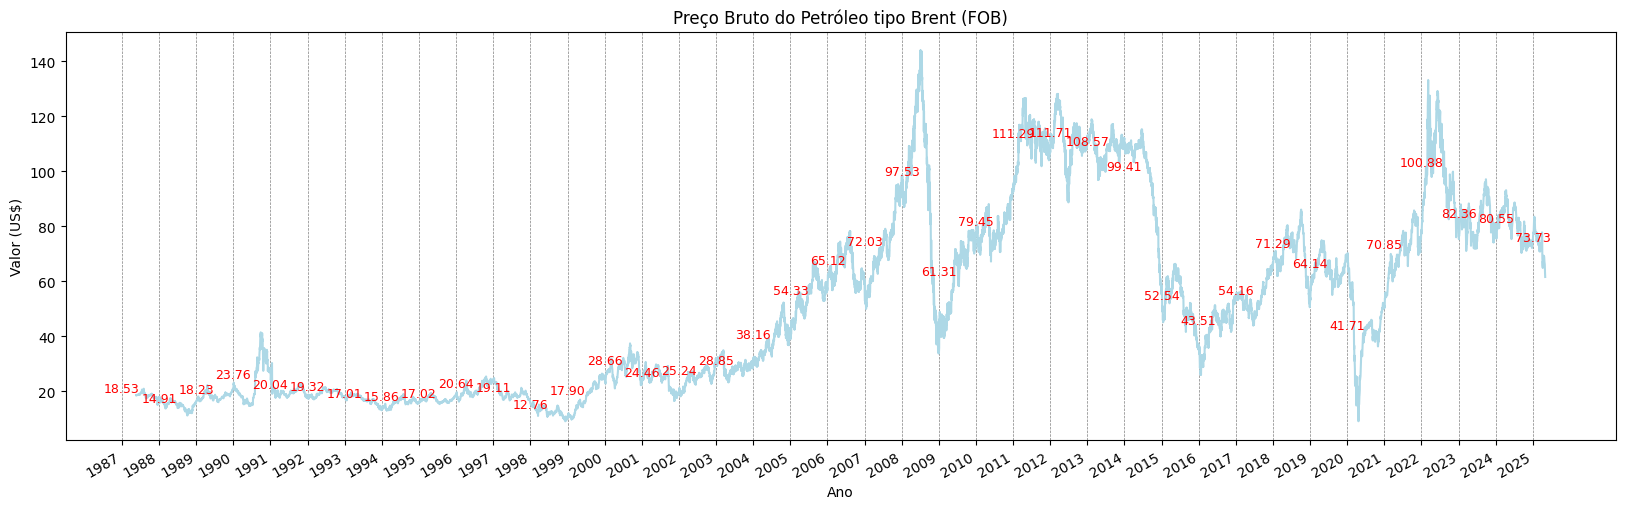

In [21]:
# Criando um array de datas com frequência anual
years = pd.date_range(
    start=pd.Timestamp(year = df_ipea_brent.index.min().year, month=1, day=1)
    ,end=pd.Timestamp(year = df_ipea_brent.index.max().year, month=1, day=1)
    ,freq='YS'
)

# Criando gráfico de linha
ax = df_ipea_brent.plot(
        y='valor'
        ,figsize=(20, 6)
        ,legend=False
        ,color= 'lightblue'
            )

ax.set_xticks(years) # Legenda horizontal
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y')) # Reternar somente o ano
plt.grid(axis='x', linestyle='--', color='gray', linewidth=0.5) # Colocando linhas na vertical no meu array

# Calcula o valor médio do petróleo brente em cada ano
for year in years:
        preco = df_ipea_brent[df_ipea_brent.index.year == year.year]['valor'].mean().round(2)
        ax.text(year, preco,f'{preco:.2f}',ha='center',va='bottom',fontsize=9,color='red',)

plt.title('Preço Bruto do Petróleo tipo Brent (FOB)')
plt.xlabel('Ano')
plt.ylabel('Valor (US$)')

plt.show()

<font size="2">

Ao analisar o gráfico anual com o período de 1987 até os dias atuais é possível visualizar uma tendencia crescente, evidenciando grandes variações em diversos anos.

Um grande destaque para os anos de 2008 e 2020, onde em 2008 atingiu o maior pico, enquanto no ano de 2020 teve uma forte queda.

Alguns fatores externos para esses anos que devem ser destacados, é que em 2008 tivemos a grande crise da bolha imobiliaria americana e em 2020 a epidemia do covid-19. Ambos afetaram a macroeconomia global, tendo relação direta com essas variações.

Analisando esse cenário é possível dizer que trata-se de uma série temporal não estacionária.

**Maiores detalhes estão no Storytelling no Streamlit**

</font>

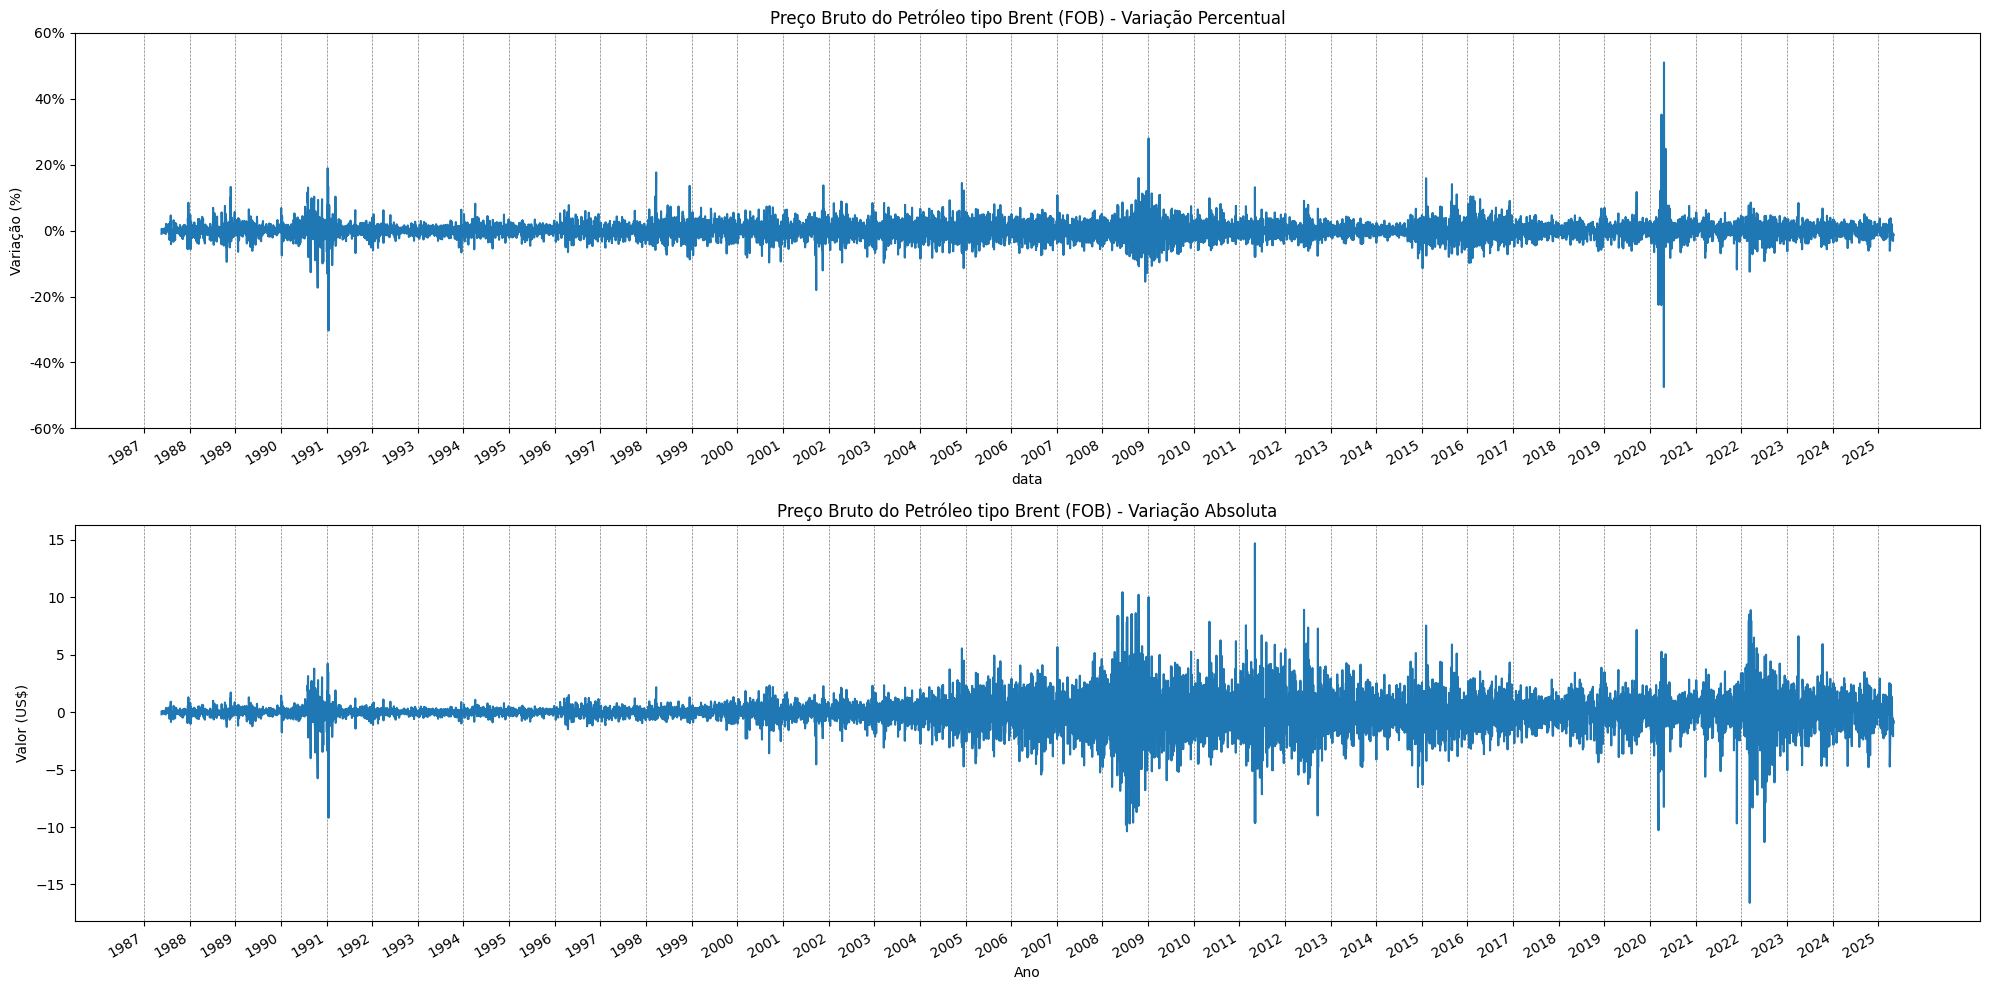

In [22]:
# Criando dataframe com variação bruta e em porcentagem
df_ipea_brent_variacao = df_ipea_brent.copy()
df_ipea_brent_variacao['variacao'] = df_ipea_brent_variacao['valor'].diff()
df_ipea_brent_variacao['p_variacao'] = ((df_ipea_brent_variacao['valor'] / df_ipea_brent_variacao['valor'].shift(1)) - 1)
df_ipea_brent_variacao

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))


df_ipea_brent_variacao.plot(
    y='p_variacao'
    ,ax=axes[0]
    ,legend=False
)

axes[0].set_xticks(years)
axes[0].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
axes[0].grid(axis='x', linestyle='--', color='gray', linewidth=0.5)
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}')) # Usando o FuncFormatter com uma função para deixar os valores na formatação de porcentagem
axes[0].set_ylim(-0.6, 0.6)
axes[0].set_title('Preço Bruto do Petróleo tipo Brent (FOB) - Variação Percentual')
axes[0].set_ylabel('Variação (%)')


df_ipea_brent_variacao.plot(
    y='variacao',
    ax=axes[1],
    legend=False
)

axes[1].set_xticks(years)
axes[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
axes[1].grid(axis='x', linestyle='--', color='gray', linewidth=0.5)
axes[1].set_title('Preço Bruto do Petróleo tipo Brent (FOB) - Variação Absoluta')
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Valor (US$)')

plt.tight_layout()
plt.show()

Uma forma de tornar a série temporal estacionária é através das variações de valores, o que permite identificar os anos com as maiores flutuações nos preços.

No Streamlit, teremos mais detalhes sobre essas informações, enquanto aqui o foco é apenas a visualização.

Abaixo, verificamos a quantidade de dias para cada ano completo, a fim de realizar a decomposição anual da série temporal.

Há outros períodos como 2001, final de 2004, 2009 e 2010, 2015 até 2017 que também podem ter sido influenciados por fatos externos com direta relação ao mercado, como por exemplo fatores geopoliticos, instabilidade economica, oferta e demanda, entre outros. É interessante reforçar que vários eventos podem causar variação no preço do petróleo, por isso ao longo da linha do tempo, está listado cada um deles e sua relação com a alta ou queda do valor.

Houve uma alteração de valor de 50% de um dia para o outro. E a média de variação é baixa durante os anos, sendo ela de -0,05%.

Com isso é possível identificar que a variação ao longo da linha temporal não é alta.

In [76]:
df_ipea_brent_variacao.describe()

,valor,variacao,p_variacao
count,11415.000000,11414.000000,11414.000000
mean,53.533153,0.003762,0.000461
std,33.056389,1.453340,0.026592
min,9.100000,-16.600000,-0.474654
25%,20.730000,-0.487500,-0.012032
50%,49.410000,0.010000,0.000142
75%,76.770000,0.540000,0.012976
max,143.950000,14.710000,0.509868


Ao considerar a diferença por variação em dolar e variação em porcentagem temos algumas informações a serem analisadas.

O maior valor de uma queda diária foi de US 16,6 e o maior percentual de queda foi de 47%.

O maior valor de aumento diário foi de US 14,71 e o maior percentual de aumento foi de 50%.

In [23]:
qtde_anos_completos = df_ipea_brent['1988-01-01':'2024-12-31'].index.year.nunique()

qtde_registros_anos_completos = df_ipea_brent['1988-01-01':'2024-12-31'].shape[0]

print(f'Quantidade de anos completos: {qtde_anos_completos}')

print(f'Quantidade de registros por ano: {(qtde_registros_anos_completos / qtde_anos_completos):.2f}')

Quantidade de anos completos: 37
Quantidade de registros por ano: 301.89


In [24]:
periodo_decomposicao = 302
decomposicao = seasonal_decompose(df_ipea_brent['1988-01-01':'2024-12-31'], model='additive', period=periodo_decomposicao)

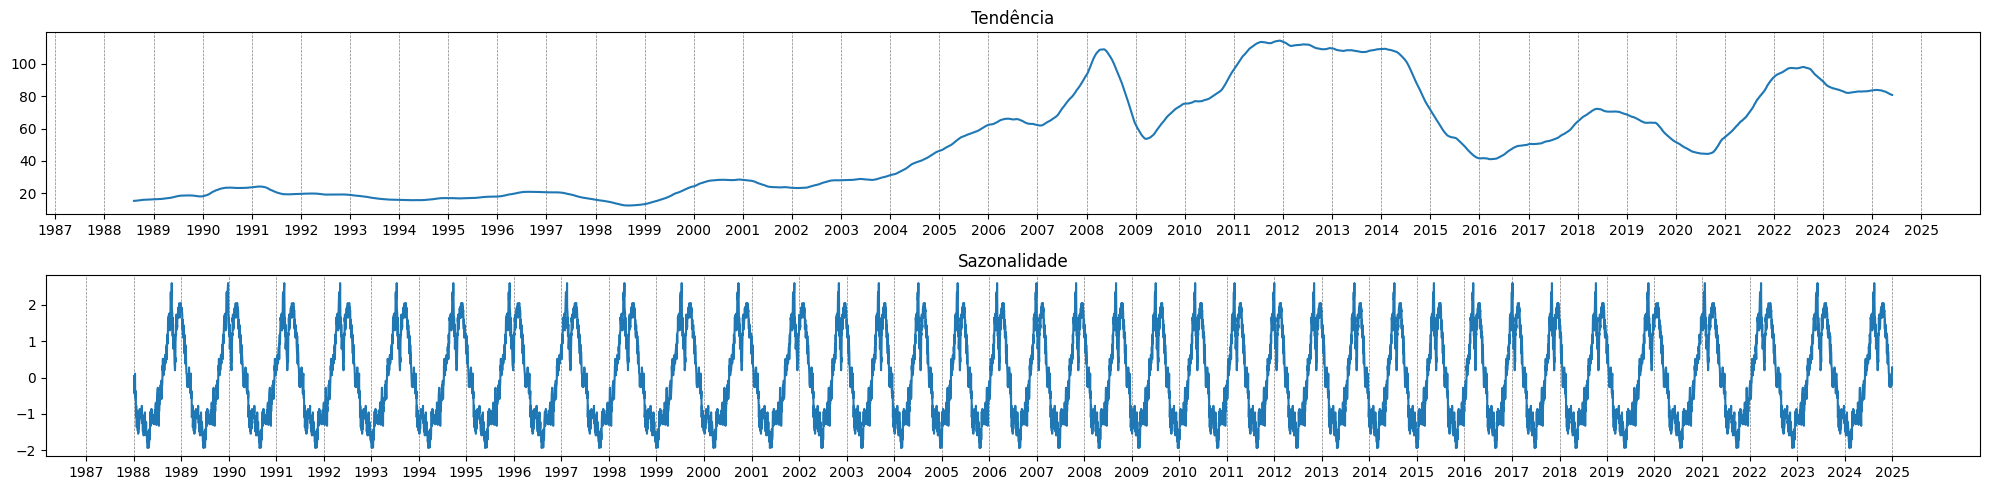

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 5)) # Criando uma área para plotar 4 gráficos

ax1.plot(decomposicao.trend) # plotando gráfico 2 'Tendência'
ax2.plot(decomposicao.seasonal) # plotando gráfico 3 'Sazonalidade'

ax1.set_title('Tendência')
ax1.set_xticks(years)
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax1.grid(axis='x', linestyle='--', color='gray', linewidth=0.5)

ax2.set_title('Sazonalidade')
ax2.set_xticks(years)
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax2.grid(axis='x', linestyle='--', color='gray', linewidth=0.5)


plt.tight_layout()

**Tendência:**
Ao analisar o gráfico acima, é possível observar uma tendência crescente no preço do petróleo Brent, com uma inclinação geral para o aumento ao longo do tempo. Foram identificados picos significativos entre 2008 e 2013, onde o valor do petróleo atingiu níveis elevados. Atualmente, a série apresenta uma leve queda, embora seja possível notar oscilações ao longo do período analisado.

**Sazonalidade:**
Através dessa linha temporal, é possível identificar um padrão de queda nos preços no início de cada ano, seguido por um aumento próximo ao meio do ano. No final do ano, há uma variação, com os preços geralmente apresentando uma queda no último trimestre.

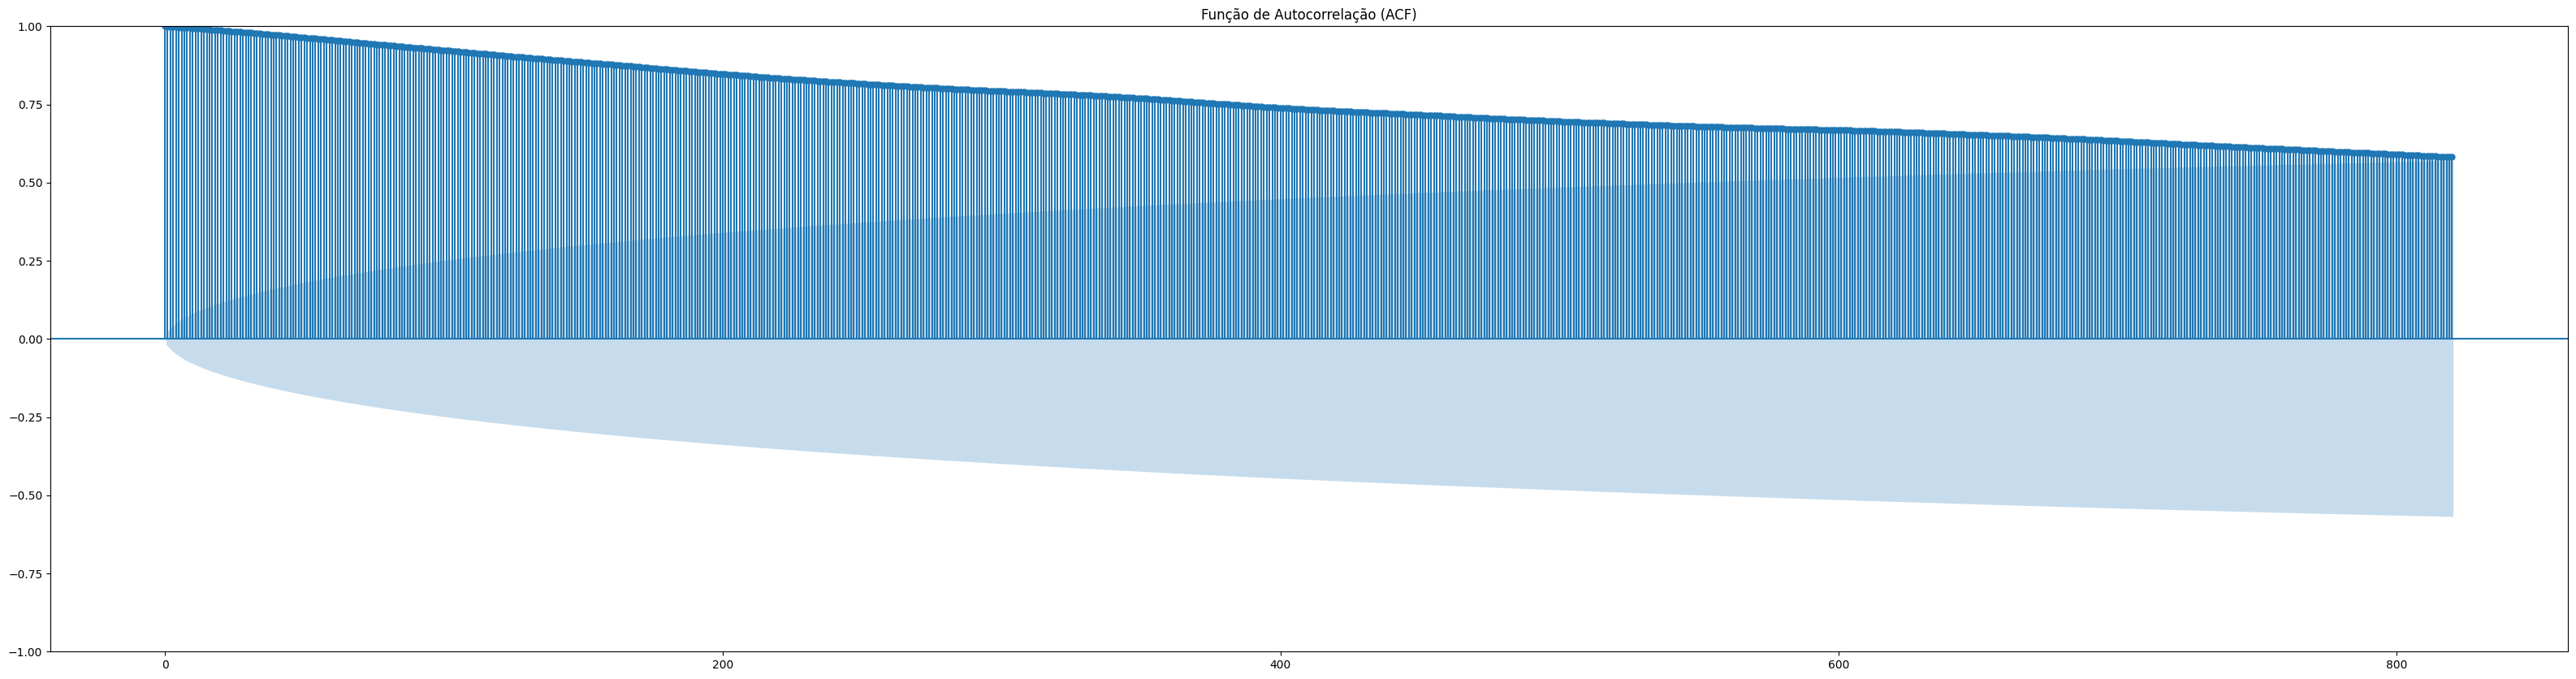

In [74]:
plt.figure(figsize=(40, 10))
plot_acf(df_ipea_brent['valor'], ax=plt.gca(), lags=820)
plt.title("Função de Autocorrelação (ACF)")
plt.show()

Ao realizar a autocorrelação ACF, observamos que a janela atinge a linha de limite no ponto 820, o que sugere que este é um ponto crítico para a autocorrelação. Esse comportamento pode ser utilizado para definir lags e criar modelos de séries temporais, levando em consideração essa defasagem.

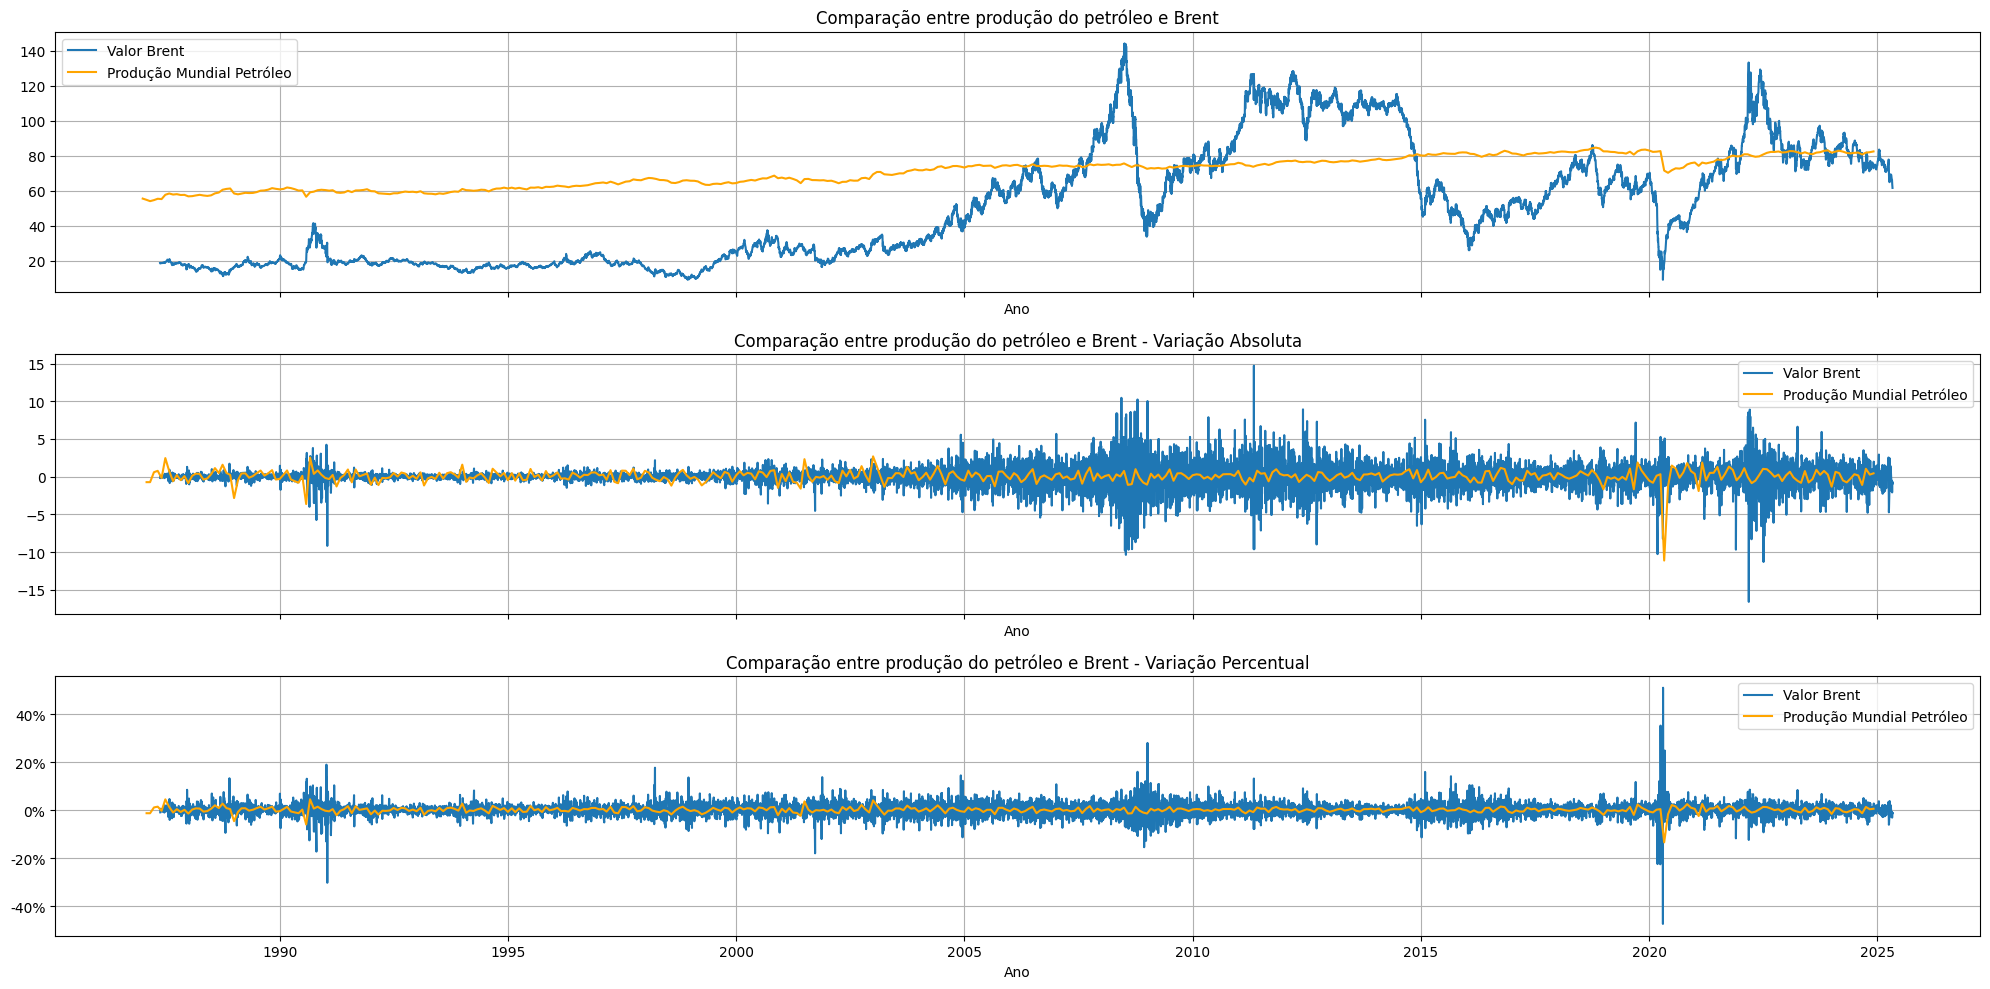

In [28]:
df_eia_prod_mundial_variacao = df_eia_prod_mundial.copy()
df_eia_prod_mundial_variacao['variacao'] = df_eia_prod_mundial['valor'].diff()
df_eia_prod_mundial_variacao['p_variacao'] = ((df_eia_prod_mundial['valor'] / df_eia_prod_mundial['valor'].shift(1)) - 1)
df_eia_prod_mundial_variacao

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)

axes[0].plot(df_ipea_brent_variacao.index, df_ipea_brent_variacao['valor'], label='Valor Brent', color='#1F77B4')
axes[0].plot(df_eia_prod_mundial_variacao.index, df_eia_prod_mundial_variacao['valor'], label='Produção Mundial Petróleo', color='orange')
axes[0].set_title('Comparação entre produção do petróleo e Brent')
axes[0].set_xlabel('Ano')
axes[0].grid(True)
axes[0].legend()

plt.tight_layout()

axes[1].plot(df_ipea_brent_variacao.index, df_ipea_brent_variacao['variacao'], label='Valor Brent', color='#1F77B4')
axes[1].plot(df_eia_prod_mundial_variacao.index, df_eia_prod_mundial_variacao['variacao'], label='Produção Mundial Petróleo', color='orange')
axes[1].set_title('Comparação entre produção do petróleo e Brent - Variação Absoluta')
axes[1].set_xlabel('Ano')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()


axes[2].plot(df_ipea_brent_variacao.index, df_ipea_brent_variacao['p_variacao'], label='Valor Brent', color='#1F77B4')
axes[2].plot(df_eia_prod_mundial_variacao.index, df_eia_prod_mundial_variacao['p_variacao'], label='Produção Mundial Petróleo', color='orange')
axes[2].set_title('Comparação entre produção do petróleo e Brent - Variação Percentual')
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
axes[2].set_xlabel('Ano')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()

plt.show()


Um dos gráficos apresentados compara as variações do preço do petróleo Brent com a produção mundial de petróleo. É possível observar que, em certos períodos, como durante a pandemia de COVID-19 (em 2020) e a Guerra do Golfo (após 1990), há variações no preço que parecem estar diretamente relacionadas a esses eventos. Trabalhar com esses DataFrames em conjunto pode agregar valor na geração do modelo, pois a interação entre oferta e demanda tem uma influência significativa sobre o preço do petróleo Brent.


## **5. Pipeline de Dados**

Nesse cenário criamos algumas classes que vão tratar os dados para serem enviados ao streamlit e para serem enviados ao modelos de Machine Learning

**Classe para criar as colunas de calendário**

In [29]:
class ColunasDatas(BaseEstimator, TransformerMixin):
  def __init__ (self, colunas_data=None):
    self.colunas_data = colunas_data

  def fit(self, df):
    return self

  def transform(self, df):

    if type(df.index) != pd.DatetimeIndex:
      print('O index do dataframe não é do tipo DatetimeIndex')
      return df
    else:
      nome_dia_semana = {
          0: 'Segunda-feira',
          1: 'Terça-feira',
          2: 'Quarta-feira',
          3: 'Quinta-feira',
          4: 'Sexta-feira',
          5: 'Sábado',
          6: 'Domingo'
      }

      df['dia'] = df.index.day
      df['mes'] = df.index.month
      df['ano'] = df.index.year
      df['dia_semana'] = df.index.weekday
      df['nome_dia_semana'] = df['dia_semana'].map(nome_dia_semana)
      df['bimestre'] = ((df['mes'] - 1) // 2) + 1
      df['trimestre'] = ((df['mes'] - 1) // 3) + 1
      df['semestre'] = ((df['mes'] - 1) // 6) + 1

      return df


**Classe para criar as colunas de variação diária absoluta e em porcentagem**

In [30]:
class ColunasVariacaoDia(BaseEstimator, TransformerMixin):
    def __init__(self, colunas_variacao='valor', df_modelo=True):
        self.colunas_variacao = colunas_variacao
        self.df_modelo = df_modelo

    def fit(self, df):
        return self

    def transform(self, df):
        if self.colunas_variacao in df.columns:
            if self.df_modelo:
              df['variacao_lag1'] = df[self.colunas_variacao].shift(1).diff()
              df['p_variacao_lag1'] = (df[self.colunas_variacao].shift(1) / df[self.colunas_variacao].shift(2) - 1)

            else:
              df['variacao'] = df[self.colunas_variacao].diff()
              df['p_variacao'] = (df[self.colunas_variacao] / df[self.colunas_variacao].shift(1) - 1)
            return df
        else:
            print(f"A coluna 'valor' não existe no DataFrame.")
            return df

**Classe para criar as colunas de variação mensal absoluta e em porcentagem**

In [31]:
class ColunasVariacaoMensal(BaseEstimator, TransformerMixin):
    def __init__(self, coluna_valor='valor', df_modelo=True):
        self.coluna_valor = coluna_valor
        self.df_modelo = df_modelo


    def fit(self, df):
        return self

    def transform(self, df):
        if all(col in df.columns for col in ['ano', 'mes', self.coluna_valor]):
          if self.df_modelo:
              medias_mensais = df.groupby(['ano', 'mes'])[self.coluna_valor].mean().shift(1).reset_index()
              medias_mensais['variacao_mensal_lag1'] = medias_mensais[self.coluna_valor].shift(1).diff()
              medias_mensais['p_variacao_mensal_lag1'] = (medias_mensais[self.coluna_valor].shift(1) / medias_mensais[self.coluna_valor].shift(2) - 1)
              medias_mensais = medias_mensais.rename(columns={'valor': 'media_mensal_lag1'})
              df = df.reset_index()
              df = df.merge(medias_mensais, on=['ano', 'mes'], how='left')
              df = df.set_index('data')
              df = df.sort_index(ascending=True)
          else:
              medias_mensais = df.groupby(['ano', 'mes'])[self.coluna_valor].mean().reset_index()
              medias_mensais['variacao_mensal'] = medias_mensais[self.coluna_valor].diff()
              medias_mensais['p_variacao_mensal'] = (medias_mensais[self.coluna_valor] / medias_mensais[self.coluna_valor].shift(1) - 1)
              medias_mensais = medias_mensais.rename(columns={'valor': 'media_mensal'})
              df = df.reset_index()
              df = df.merge(medias_mensais, on=['ano', 'mes'], how='left')
              df = df.set_index('data')
              df = df.sort_index(ascending=True)
          return df
        else:
            print("As colunas 'ano', 'mes' ou 'valor' não existem no DataFrame.")
            return df

**Classe para criar as colunas de variação anual absoluta e em porcentagem**

In [32]:
class ColunasVariacaoAnual(BaseEstimator, TransformerMixin):
    def __init__(self, coluna_valor='valor', df_modelo=True):
        self.coluna_valor = coluna_valor
        self.df_modelo = df_modelo

    def fit(self, df):
        return self

    def transform(self, df):
        if all(col in df.columns for col in ['ano', self.coluna_valor]):
          if self.df_modelo:
              medias_anuais = df.groupby('ano')[self.coluna_valor].mean().shift(1).reset_index()
              medias_anuais['variacao_anual_lag1'] = medias_anuais[self.coluna_valor].shift(1).diff()
              medias_anuais['p_variacao_anual_lag1'] = (medias_anuais[self.coluna_valor].shift(1) / medias_anuais[self.coluna_valor].shift(2) - 1)
              medias_anuais = medias_anuais.rename(columns={'valor': 'media_anual_lag1'})
              df = df.reset_index()
              df = df.merge(medias_anuais, on='ano', how='left')
              df = df.set_index('data')
              df = df.sort_index(ascending=True)
          else:
              medias_anuais = df.groupby('ano')[self.coluna_valor].mean().reset_index()
              medias_anuais['variacao_anual'] = medias_anuais[self.coluna_valor].diff()
              medias_anuais['p_variacao_anual'] = (medias_anuais[self.coluna_valor] / medias_anuais[self.coluna_valor].shift(1) - 1)
              medias_anuais = medias_anuais.rename(columns={'valor': 'media_anual'})
              df = df.reset_index()
              df = df.merge(medias_anuais, on='ano', how='left')
              df = df.set_index('data')
              df = df.sort_index(ascending=True)
          return df
        else:
            print("As colunas 'ano' ou 'valor' não existem no DataFrame.")
            return df

**Classe para criar as colunas de média movel e desvio padrão movel**

In [33]:
class RollingFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_rolling=28):
        self.n_rolling = n_rolling
        self.colunas_rolling = ['valor', 'variacao', 'p_variacao']

    def fit(self, df):
        return self

    def transform(self, df):
        for col in self.colunas_rolling:
            if col in df.columns:
                df[f'rolling_mean_{col}_{self.n_rolling}'] = (
                    df[col]
                    .rolling(window=self.n_rolling)
                    .mean()
                    .shift(1)
                )

                df[f'rolling_std_{col}_{self.n_rolling}'] = (
                    df[col]
                    .rolling(window=self.n_rolling)
                    .std()
                    .shift(1)
                )
            else:
                print(f"Coluna '{col}' não encontradas no DataFrame para Rolling")

        return df

**Classe para criar as colunas de janelas (lag) do campo valor**

In [34]:
class LagsFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_lags=5):
        self.n_lags = n_lags
        self.colunas_alvo = ['valor']

    def fit(self, df):
        return self

    def transform(self, df):
        for col in self.colunas_alvo:
            if col in df.columns:
                for lag in range(1, self.n_lags + 1):
                    df[f'lag_{lag}_{col}'] = df[col].shift(lag)
            else:
                print('Coluna valor não encontrada no DataFrame')

        return df

**Classe para deletar os valores nulos que foram criados com a funções shift e rolling**

In [35]:
class DeletarNulos(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # Nenhum parâmetro necessário

    def fit(self, df, y=None):
        return self

    def transform(self, df):
        df.dropna(inplace=True)
        return df

### **5.1. Gerando CSV para Streamlit**

Aqui geramos um pipeline de dados que gera o csv dos arquivos para o streamlit

In [36]:
def pipeline_ipea_streamlit(df):
    pipeline_dados_ipea_streamlit = Pipeline([
         ('ColunasDatas', ColunasDatas())
        ,('ColunasVariacaoDia', ColunasVariacaoDia(df_modelo = False))
        ,('ColunasVariacaoMensal', ColunasVariacaoMensal(df_modelo = False))
        ,('ColunasVariacaoAnual', ColunasVariacaoAnual(df_modelo = False))
        ,('DeletarNulos', DeletarNulos())
    ])
    df_pipeline_ipea_streamlit = pipeline_dados_ipea_streamlit.fit_transform(df)
    df_pipeline_ipea_streamlit.to_csv('df_ipea_brent.csv')
    return print('csv df_ipea_brent criado com sucesso!')

def pipeline_eia_streamlit(df):
    pipeline_dados_eia_streamlit = Pipeline([
         ('ColunasDatas', ColunasDatas())
        ,('ColunasVariacaoMensal', ColunasVariacaoMensal(df_modelo = False))
        ,('ColunasVariacaoAnual', ColunasVariacaoAnual(df_modelo = False))
        ,('DeletarNulos', DeletarNulos())
    ])
    df_pipeline_eia_streamlit = pipeline_dados_eia_streamlit.fit_transform(df)
    df_pipeline_eia_streamlit.to_csv('df_eia_prod_mundial.csv')
    return print('csv df_eia_prod_mundial criado com sucesso!')

In [37]:
pipeline_ipea_streamlit(df_ipea_brent)

csv df_ipea_brent criado com sucesso!


In [38]:
pipeline_eia_streamlit(df_eia_prod_mundial)

csv df_eia_prod_mundial criado com sucesso!


### **5.2. Gerando DataFrame para os modelos**

Aqui geramos o pipeline de dados referente aos dados que irão ao modelo

In [39]:
def pipeline_ipea_modelo(df):
    pipeline_dados_ipea_modelo = Pipeline([
         ('ColunasDatas', ColunasDatas())
        ,('ColunasVariacaoDia', ColunasVariacaoDia())
        ,('ColunasVariacaoMensal', ColunasVariacaoMensal())
        ,('ColunasVariacaoAnual', ColunasVariacaoAnual())
        ,('RollingFeatures', RollingFeatures())
        ,('LagsFeatures', LagsFeatures())
        ,('DeletarNulos', DeletarNulos())
    ])
    df_pipeline_ipea_modelo = pipeline_dados_ipea_modelo.fit_transform(df)
    return df_pipeline_ipea_modelo

def pipeline_eia_modelo(df):
    pipeline_dados_eia_modelo = Pipeline([
         ('ColunasDatas', ColunasDatas())
        ,('ColunasVariacaoMensal', ColunasVariacaoMensal())
        ,('ColunasVariacaoAnual', ColunasVariacaoAnual())
        ,('LagsFeatures', LagsFeatures())
        ,('DeletarNulos', DeletarNulos())
    ])
    df_pipeline_eia_modelo = pipeline_dados_eia_modelo.fit_transform(df)
    return df_pipeline_eia_modelo

In [40]:
df_ipea_brent_modelo = pipeline_ipea_modelo(df_ipea_brent)
df_eia_prod_mundial_modelo = pipeline_eia_modelo(df_eia_prod_mundial)

## **6. Selecionando Feautures**

### **6.1 Juntando as bases de dados de produção e Brent**

Embora esse processo pudesse ser estruturado como um pipeline, optamos por apresentá-lo dessa forma para explicar com mais clareza como iremos integrar os dados do preço do Brent com os dados de produção mundial de petróleo.

Nesta etapa, adicionamos o prefixo "Prod_Ano_Ant_" a todas as colunas, exceto às colunas de mês e ano, para diferenciar esses dados dos referentes ao Brent.

Em seguida, incrementamos o valor do ano em 1. Isso foi feito para associar a produção de petróleo de anos anteriores ao respectivo ano atual, criando assim um lag (defasagem) temporal dos dados de produção.

In [41]:
colunas_preservadas = ['mes', 'ano']
df_eia_prod_mundial_modelo.columns = [col if col in colunas_preservadas else 'Prod_Ano_Ant_' + col for col in df_eia_prod_mundial_modelo.columns]
df_eia_prod_mundial_modelo['ano'] += 1
df_eia_prod_mundial_modelo.head()

,Prod_Ano_Ant_valor,Prod_Ano_Ant_dia,mes,ano,Prod_Ano_Ant_dia_semana,Prod_Ano_Ant_nome_dia_semana,Prod_Ano_Ant_bimestre,Prod_Ano_Ant_trimestre,Prod_Ano_Ant_semestre,Prod_Ano_Ant_media_mensal_lag1,Prod_Ano_Ant_variacao_mensal_lag1,Prod_Ano_Ant_p_variacao_mensal_lag1,Prod_Ano_Ant_media_anual_lag1,Prod_Ano_Ant_variacao_anual_lag1,Prod_Ano_Ant_p_variacao_anual_lag1,Prod_Ano_Ant_lag_1_valor,Prod_Ano_Ant_lag_2_valor,Prod_Ano_Ant_lag_3_valor,Prod_Ano_Ant_lag_4_valor,Prod_Ano_Ant_lag_5_valor
data,,,,,,,,,,,,,,,,,,,,
1990-01-01,60.75,1,1,1991,0,Segunda-feira,1,1,1,61.06,0.86,0.014196,59.434167,1.991667,0.035332,61.06,61.44,60.58,60.14,60.00
1990-02-01,61.01,1,2,1991,3,Quinta-feira,1,1,1,60.75,-0.38,-0.006185,59.434167,1.991667,0.035332,60.75,61.06,61.44,60.58,60.14
1990-03-01,61.83,1,3,1991,3,Quinta-feira,2,1,1,61.01,-0.31,-0.005077,59.434167,1.991667,0.035332,61.01,60.75,61.06,61.44,60.58
1990-04-01,61.46,1,4,1991,6,Domingo,2,2,1,61.83,0.26,0.004280,59.434167,1.991667,0.035332,61.83,61.01,60.75,61.06,61.44
1990-05-01,60.86,1,5,1991,1,Terça-feira,3,2,1,61.46,0.82,0.013440,59.434167,1.991667,0.035332,61.46,61.83,61.01,60.75,61.06


Nesta etapa, realizamos a junção dos dois DataFrames com base nas colunas de ano e mês. Por esse motivo, optamos por não renomear essas colunas na etapa anterior, garantindo que os dados pudessem ser combinados corretamente.

In [42]:
df_ipea_brent_modelo.reset_index(inplace=True)
df_ipea_brent_modelo = df_ipea_brent_modelo.merge(df_eia_prod_mundial_modelo, on=['mes', 'ano'], how='left')
df_ipea_brent_modelo.set_index('data', inplace=True)
df_ipea_brent_modelo.head(5)

,valor,dia,mes,ano,dia_semana,nome_dia_semana,bimestre,trimestre,semestre,variacao,...,Prod_Ano_Ant_variacao_mensal_lag1,Prod_Ano_Ant_p_variacao_mensal_lag1,Prod_Ano_Ant_media_anual_lag1,Prod_Ano_Ant_variacao_anual_lag1,Prod_Ano_Ant_p_variacao_anual_lag1,Prod_Ano_Ant_lag_1_valor,Prod_Ano_Ant_lag_2_valor,Prod_Ano_Ant_lag_3_valor,Prod_Ano_Ant_lag_4_valor,Prod_Ano_Ant_lag_5_valor
data,,,,,,,,,,,,,,,,,,,,,
1990-01-02,21.20,2,1,1990,1,Terça-feira,1,1,1,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,22.65,3,1,1990,2,Quarta-feira,1,1,1,1.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,22.50,4,1,1990,3,Quinta-feira,1,1,1,-0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,23.13,5,1,1990,4,Sexta-feira,1,1,1,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,21.38,8,1,1990,0,Segunda-feira,1,1,1,-1.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como gerou diversas duplicidades realizamos o processo de remover os dados nulos

In [43]:
df_ipea_brent_modelo.isna().sum().sum()

np.int64(4608)

In [44]:
df_ipea_brent_modelo.dropna(inplace=True)

In [45]:
df_ipea_brent_modelo.head()

,valor,dia,mes,ano,dia_semana,nome_dia_semana,bimestre,trimestre,semestre,variacao,...,Prod_Ano_Ant_variacao_mensal_lag1,Prod_Ano_Ant_p_variacao_mensal_lag1,Prod_Ano_Ant_media_anual_lag1,Prod_Ano_Ant_variacao_anual_lag1,Prod_Ano_Ant_p_variacao_anual_lag1,Prod_Ano_Ant_lag_1_valor,Prod_Ano_Ant_lag_2_valor,Prod_Ano_Ant_lag_3_valor,Prod_Ano_Ant_lag_4_valor,Prod_Ano_Ant_lag_5_valor
data,,,,,,,,,,,,,,,,,,,,,
1991-01-02,26.78,2,1,1991,2,Quarta-feira,1,1,1,-1.57,...,0.86,0.014196,59.434167,1.991667,0.035332,61.06,61.44,60.58,60.14,60.0
1991-01-03,25.05,3,1,1991,3,Quinta-feira,1,1,1,-1.73,...,0.86,0.014196,59.434167,1.991667,0.035332,61.06,61.44,60.58,60.14,60.0
1991-01-04,24.08,4,1,1991,4,Sexta-feira,1,1,1,-0.97,...,0.86,0.014196,59.434167,1.991667,0.035332,61.06,61.44,60.58,60.14,60.0
1991-01-07,25.93,7,1,1991,0,Segunda-feira,1,1,1,1.85,...,0.86,0.014196,59.434167,1.991667,0.035332,61.06,61.44,60.58,60.14,60.0
1991-01-08,25.73,8,1,1991,1,Terça-feira,1,1,1,-0.20,...,0.86,0.014196,59.434167,1.991667,0.035332,61.06,61.44,60.58,60.14,60.0


### **6.2 Variáveis para Modelo com previsão com a média movel e valor de 7 dias atrás**

Vamos criar 2 colunas que vamos usar em 2 modelos baseline para comparar com os modelos avançados

In [46]:
df_ipea_brent_modelo['pred_seasonal_week_naive'] = df_ipea_brent_modelo['valor'].shift(7)
df_ipea_brent_modelo['pred_avarege_naive'] = df_ipea_brent_modelo['valor'].rolling(5).mean().shift(1)

### **6.3 Selecionando as variáveis para os modelos avançados**

Definimos um período de corte para treinar o modelo. Como o gráfico de autocorrelação indicou uma defasagem significativa (até 800 lags), optamos por utilizar os dados a partir de 2015, garantindo assim um volume adequado de observações recentes e relevantes para alimentar o modelo.

In [47]:
df_para_modelo = df_ipea_brent_modelo.loc[df_ipea_brent_modelo['ano'] >= 2015]

Nesta etapa, removemos as colunas relacionadas ao nome da semana, pois essas informações não são úteis para o modelo nem para a análise de autocorrelação.

In [48]:
matriz_correlacao = df_para_modelo.drop(columns=['nome_dia_semana','Prod_Ano_Ant_nome_dia_semana','pred_seasonal_week_naive','pred_avarege_naive']).corr()

Visualizamos a autocorrelação com o nosso target 'Valor'

In [49]:
matriz_correlacao['valor'].sort_values(ascending=False)

,valor
valor,1.000000
lag_1_valor,0.996335
lag_2_valor,0.992861
lag_3_valor,0.989975
lag_4_valor,0.987141
lag_5_valor,0.983831
rolling_mean_valor_28,0.969082
media_mensal_lag1,0.935731
ano,0.656270
rolling_std_variacao_28,0.380057


Por fim criação um array com as colunas que tem a melhores correlação

In [50]:
alta_correlacao = matriz_correlacao['valor'].loc[(matriz_correlacao['valor'] < -0.3) | (matriz_correlacao['valor'] > 0.5)].index.values

alta_correlacao = np.append(alta_correlacao, ['dia','mes','trimestre','semestre'])

list(alta_correlacao)

['valor',
 'ano',
 'media_mensal_lag1',
 'rolling_mean_valor_28',
 'rolling_std_p_variacao_28',
 'lag_1_valor',
 'lag_2_valor',
 'lag_3_valor',
 'lag_4_valor',
 'lag_5_valor',
 'Prod_Ano_Ant_media_mensal_lag1',
 'Prod_Ano_Ant_lag_1_valor',
 'Prod_Ano_Ant_lag_2_valor',
 'Prod_Ano_Ant_lag_3_valor',
 'Prod_Ano_Ant_lag_4_valor',
 'Prod_Ano_Ant_lag_5_valor',
 'dia',
 'mes',
 'trimestre',
 'semestre']

## **7. Selecionando período de treino e teste**

Selecionamos o perioro de treino e teste. Sendo o teste 22 dias

In [51]:
filtro_previsao = '2025-04-01'

treino = df_para_modelo[df_para_modelo.index < filtro_previsao]
teste = df_para_modelo[df_para_modelo.index >= filtro_previsao]

In [52]:
print(treino.shape)
print(teste.shape)

(3006, 50)
(22, 50)


## **8. Modelos Baseline**

Nessa etapa geramos alguns modelos que são com verifica a média movel e coloca o período da semana anterior.

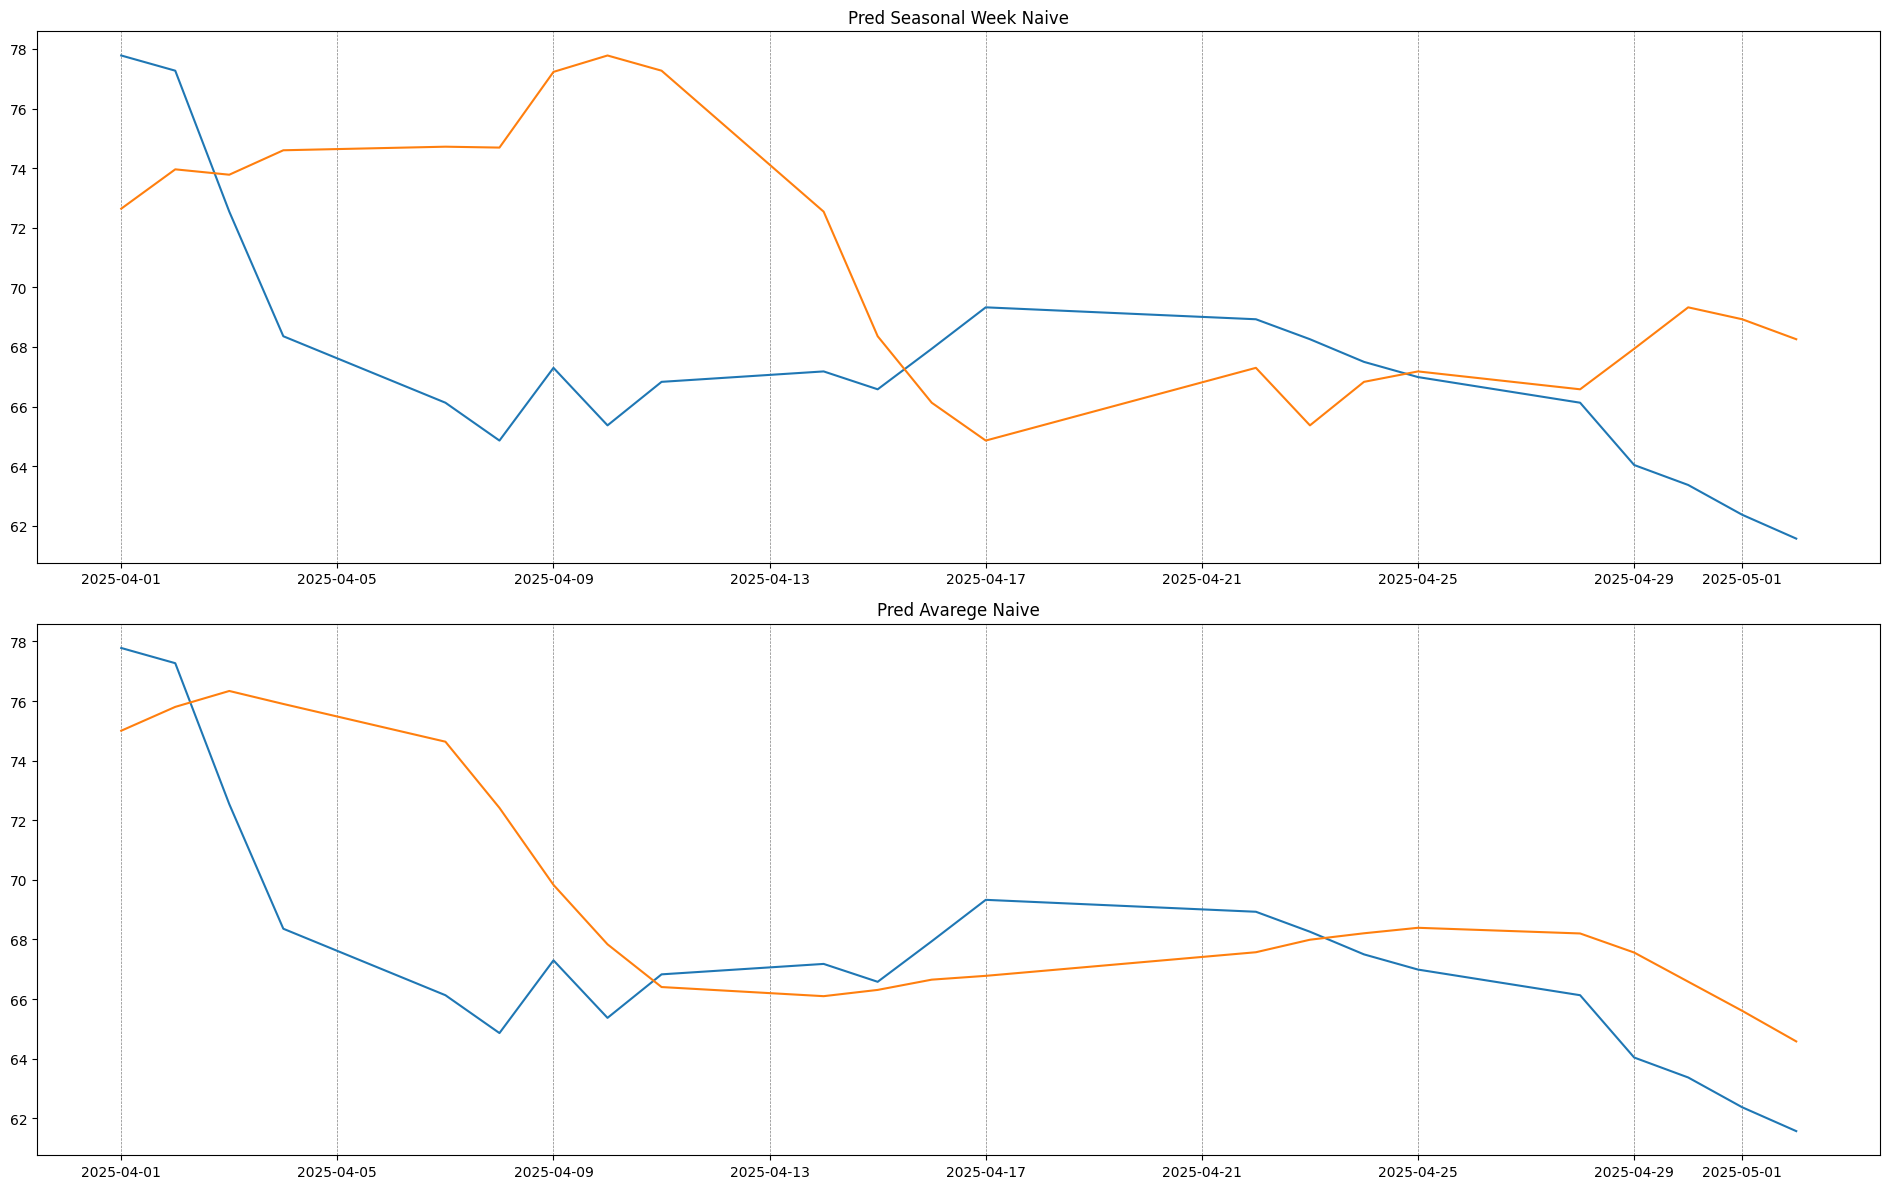

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (19, 12))


ax1.plot(teste['valor'])
ax1.plot(teste['pred_seasonal_week_naive'])
ax1.set_title('Pred Seasonal Week Naive')
ax1.grid(axis='x', linestyle='--', color='gray', linewidth=0.5)

ax2.plot(teste['valor'])
ax2.plot(teste['pred_avarege_naive'])
ax2.set_title('Pred Avarege Naive')
ax2.grid(axis='x', linestyle='--', color='gray', linewidth=0.5)

plt.tight_layout()

In [54]:
resultados_baseline = pd.DataFrame(
    {
        "Modelo": ["pred_seasonal_week_naive", "pred_avarege_naive"],
        "MAPE": [mean_absolute_percentage_error(teste['valor'], teste['pred_seasonal_week_naive']),
                  mean_absolute_percentage_error(teste['valor'], teste['pred_avarege_naive'])
                  ]
    }).sort_values("MAPE")

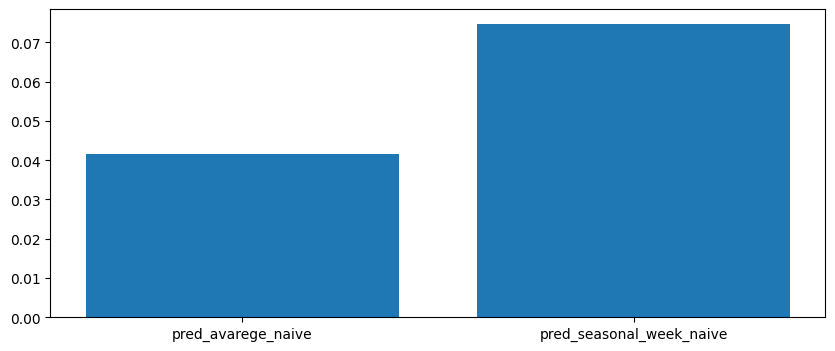

In [55]:
figure = plt.figure(figsize=(10, 4))
plt.bar(resultados_baseline['Modelo'],resultados_baseline['MAPE'])
plt.show()

## **9. Modelos Avançados**

XGBRegressor

In [56]:
# Definindo as features and target
X_train = treino[alta_correlacao].drop(columns=['valor'])
y_train = treino[alta_correlacao]['valor']
X_test = teste[alta_correlacao].drop(columns=['valor'])
y_test = teste[alta_correlacao]['valor']

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_estimators': 500
}

xgb = XGBRegressor(**params)


# Ele vai treinar com toda a base de dados
xgb.fit(X_train, y_train)

# Vai fazer a predição com toda a base de dados
xgb_pred = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_pred)
print(f'XGB Completo RMSE: {mse_xgb:.2f}')

XGB Completo RMSE: 6.78


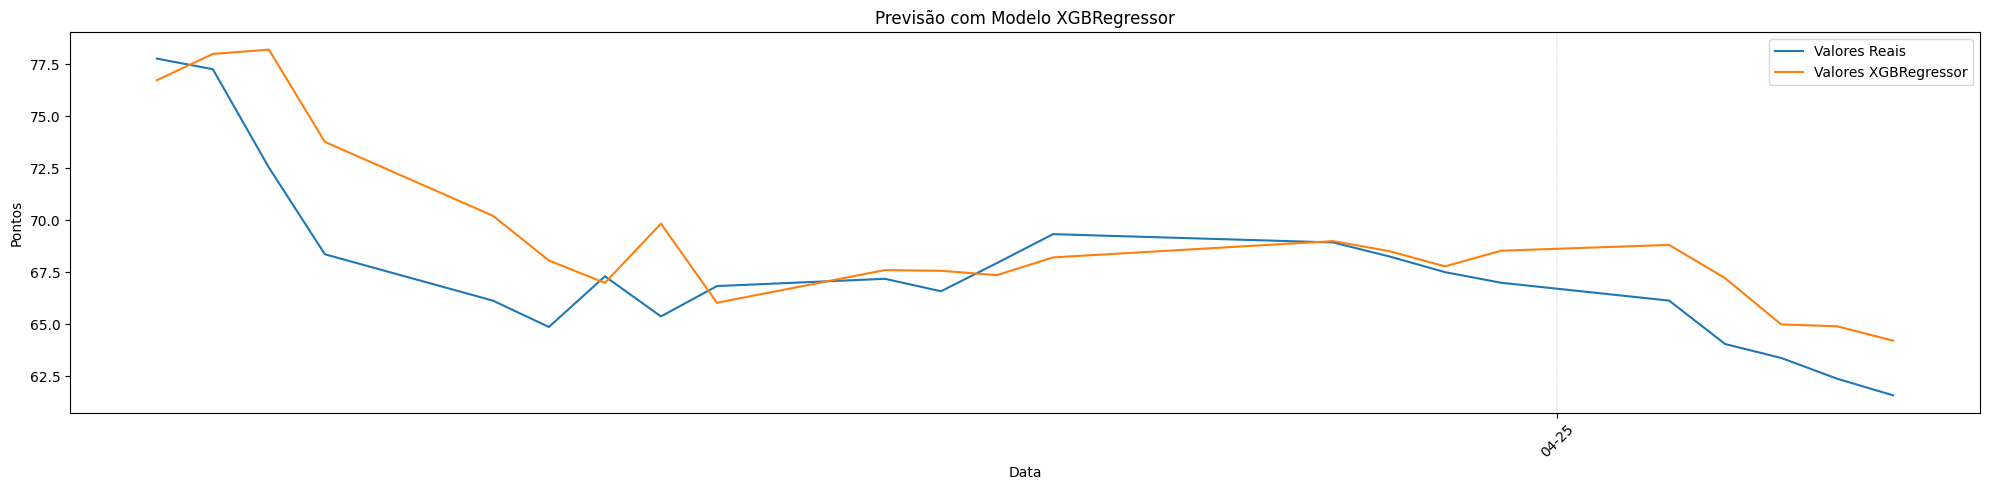

In [57]:
xgb_pred = pd.DataFrame({'y_test': y_test.values, 'xgb_pred': xgb_pred, 'ds': teste.index.values})

plt.figure(figsize=(20, 5))
ax = sns.lineplot(x='ds', y='y_test', data=xgb_pred, label='Valores Reais')
sns.lineplot(x='ds', y='xgb_pred', data=xgb_pred, label='Valores XGBRegressor')

ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=30))
plt.grid(axis='x', linestyle='--', color='gray', linewidth=0.2)

plt.xlabel('Data')
plt.ylabel('Pontos')
plt.title('Previsão com Modelo XGBRegressor')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Prophet

In [58]:
# Criando a base de treino para o Prophet
train_prophet = treino[alta_correlacao].reset_index()
# O Prophet tem um padrão de data e valor-alvo sendo: 'ds' para a data e 'y' para o alvo. Então, renomeamos as colunas.
train_prophet = train_prophet.rename(columns={'data': 'ds', 'valor': 'y'})

# Nos valores que vamos testar, removemos a coluna "valor" e formatamos os testes da mesma forma que o treino.
teste_prophet = teste[alta_correlacao].drop(columns=['valor']).reset_index()
teste_prophet = teste_prophet.rename(columns={'data': 'ds'})

In [59]:
# No Prophet os regressores 'regresssors' São  variáveis externas que você pode incluir no modelo para ajudar a melhorar as previsões.
# O teste_prophet não possui a coluna 'último', então removemos a coluna data 'ds'. Dessa forma, todas as variáveis restantes serão usadas como features para auxiliar o Prophet nas previsões.
regressors = teste_prophet.drop(columns=['ds']).columns.tolist()
regressors

['ano',
 'media_mensal_lag1',
 'rolling_mean_valor_28',
 'rolling_std_p_variacao_28',
 'lag_1_valor',
 'lag_2_valor',
 'lag_3_valor',
 'lag_4_valor',
 'lag_5_valor',
 'Prod_Ano_Ant_media_mensal_lag1',
 'Prod_Ano_Ant_lag_1_valor',
 'Prod_Ano_Ant_lag_2_valor',
 'Prod_Ano_Ant_lag_3_valor',
 'Prod_Ano_Ant_lag_4_valor',
 'Prod_Ano_Ant_lag_5_valor',
 'dia',
 'mes',
 'trimestre',
 'semestre']

In [60]:
m = Prophet() # Instanciando a modelo Prophet

# Adicionando os regressores, para não precisar digitar para regressos usamos o for (loop)
for regressor in regressors:
    m.add_regressor(regressor)

# Treinando o modelo com os dados existentes
m.fit(train_prophet)

# Realizando a previsão com os dados de teste, sem o valor último e com os regressores.
forecast = m.predict(teste_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5szucrnb/qub6ex1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5szucrnb/ut8s_60k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44822', 'data', 'file=/tmp/tmp5szucrnb/qub6ex1e.json', 'init=/tmp/tmp5szucrnb/ut8s_60k.json', 'output', 'file=/tmp/tmp5szucrnb/prophet_model7hjbo3tf/prophet_model-20250513031455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:14:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:14:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [61]:
# Criando o dataset com as previsões, valores reais e a data
df_prophet = pd.merge(teste['valor'].reset_index().rename(columns={'data': 'ds', 'valor': 'y'}),forecast[['ds', 'yhat']], on='ds', how='left')

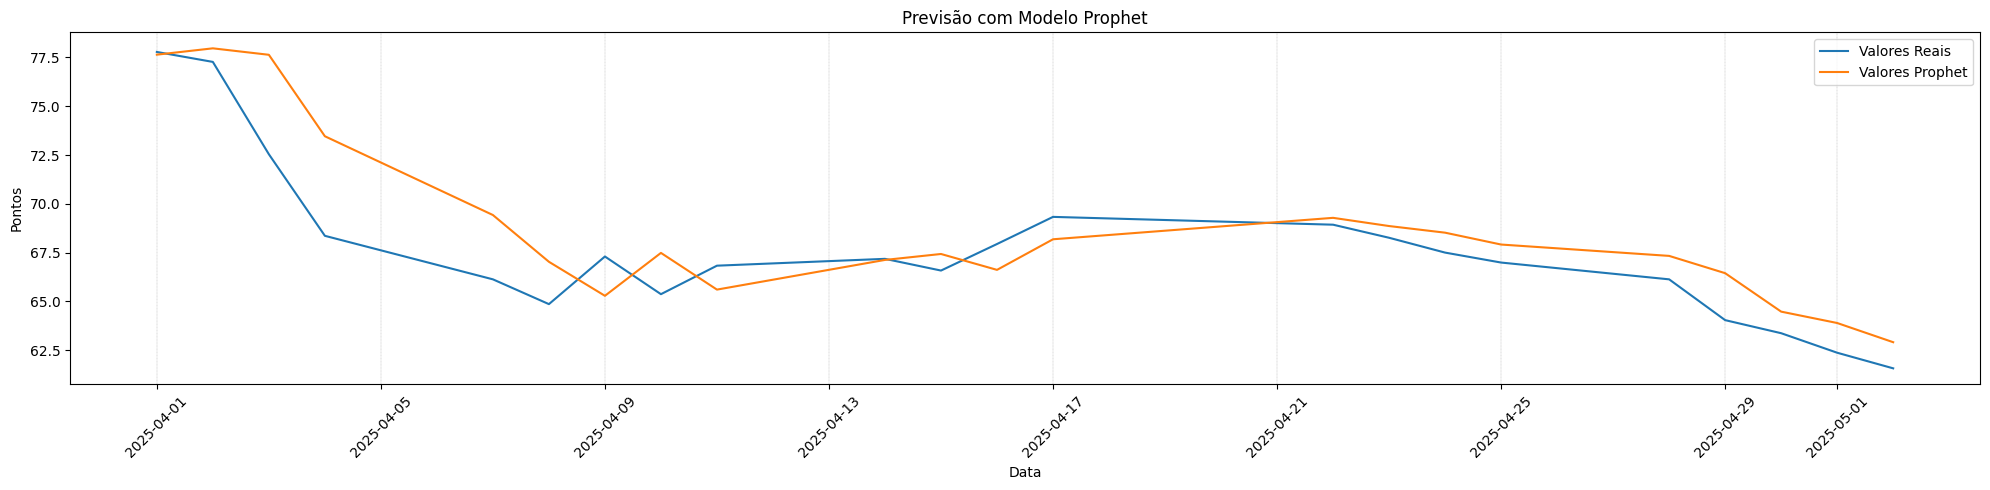

In [62]:
plt.figure(figsize=(20, 5))
ax = sns.lineplot(x='ds', y='y', data=df_prophet, label='Valores Reais')
ax2 = sns.lineplot(x='ds', y='yhat', data=df_prophet, label='Valores Prophet')

#ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%y'))
#ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=30))
plt.grid(axis='x', linestyle='--', color='gray', linewidth=0.2)

plt.xlabel('Data')
plt.ylabel('Pontos')
plt.title('Previsão com Modelo Prophet')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
# 1. Preparando os dados
X_train_lgb = treino[alta_correlacao].drop(columns=['valor']).reset_index(drop=True)
y_train_lgb = treino['valor'].reset_index(drop=True)

X_test_lgb = teste[alta_correlacao].drop(columns=['valor']).reset_index(drop=True)
y_test_lgb = teste['valor'].reset_index(drop=True)

# 2. Treinando o modelo
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
model.fit(X_train_lgb, y_train_lgb)

# 3. Fazendo previsões
y_pred_lgb = model.predict(X_test_lgb)

# 4. Avaliando a performance
mse_xgb = mean_squared_error(y_test_lgb, y_pred_lgb)
print(f'XGB Completo RMSE: {mse_xgb:.2f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 3006, number of used features: 19
[LightGBM] [Info] Start training from score 64.687861
XGB Completo RMSE: 4.06


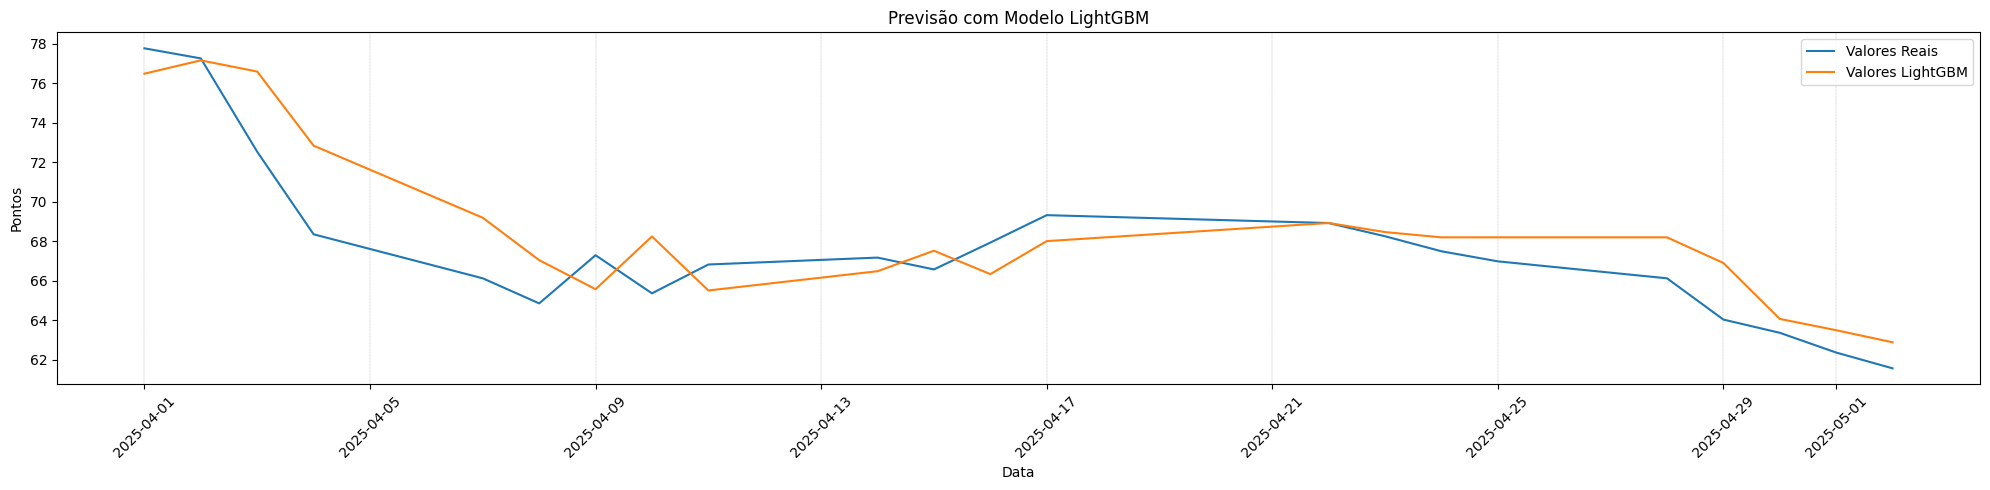

In [64]:
# 1. Criando o DataFrame com valores reais e previstos
df_lgb = teste[['valor']].reset_index().rename(columns={'data': 'ds', 'valor': 'y'})
df_lgb['yhat'] = y_pred_lgb  # adicionando a previsão

# 2. Gráfico com estilo igual ao do Prophet
plt.figure(figsize=(20, 5))

# Linha dos valores reais
ax = sns.lineplot(x='ds', y='y', data=df_lgb, label='Valores Reais')

# Linha da previsão do LightGBM
sns.lineplot(x='ds', y='yhat', data=df_lgb, label='Valores LightGBM')

plt.grid(axis='x', linestyle='--', color='gray', linewidth=0.2)
plt.xlabel('Data')
plt.ylabel('Pontos')
plt.title('Previsão com Modelo LightGBM')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **10. Validando Modelos**

Validando os resultados dos modelos

In [65]:
mae_prophet = mean_absolute_error(df_prophet['y'], df_prophet['yhat'])
rmse_prophet = mean_squared_error(df_prophet['y'], df_prophet['yhat'])
mape_prophet = mean_absolute_percentage_error(df_prophet['y'], df_prophet['yhat'])
acuracia_prophet = 1 - mape_prophet

mae_xgb = mean_absolute_error(xgb_pred['y_test'], xgb_pred['xgb_pred'])
rmse_xgb = mean_squared_error(xgb_pred['y_test'], xgb_pred['xgb_pred'])
mape_xgb = mean_absolute_percentage_error(xgb_pred['y_test'], xgb_pred['xgb_pred'])
acuracia_xgb = 1 - mape_xgb

mae_LightGBM = mean_absolute_error(y_test_lgb.values, y_pred_lgb)
rmse_LightGBM = mean_squared_error(y_test_lgb.values, y_pred_lgb)
mape_LightGBM = mean_absolute_percentage_error(y_test_lgb.values, y_pred_lgb)
acuracia_LightGBM = 1 - mape_LightGBM

mae_seasonal_naive = mean_absolute_error(teste['valor'], teste['pred_seasonal_week_naive'].values)
rmse_seasonal_naive = mean_squared_error(teste['valor'], teste['pred_seasonal_week_naive'].values)
mape_seasonal_naive = mean_absolute_percentage_error(teste['valor'], teste['pred_seasonal_week_naive'].values)
acuracia_seasonal_naive = 1 - mape_seasonal_naive

mae_avarege_naive = mean_absolute_error(teste['valor'], teste['pred_avarege_naive'].values)
rmse_avarege_naive = mean_squared_error(teste['valor'], teste['pred_avarege_naive'].values)
mape_avarege_naive = mean_absolute_percentage_error(teste['valor'], teste['pred_avarege_naive'].values)
acuracia_avarege_naive = 1 - mape_seasonal_naive


# gerando um dataframe com o resultado das métricas de erro para cada modelo
resultados = pd.DataFrame(
    {
        "Modelo": ["XGBoost","Phophet", "LightGBM", "Seasonal Naive", "Avarege"],
        "MAE": [mae_xgb, mae_prophet, mae_LightGBM, mae_seasonal_naive,mae_avarege_naive],
        "RMSE": [rmse_xgb, rmse_prophet, rmse_LightGBM, rmse_seasonal_naive,rmse_avarege_naive],
        "MAPE (%)": [mape_xgb, mape_prophet, mape_LightGBM, mape_seasonal_naive,mape_avarege_naive],
        "Acuracia": [acuracia_xgb, acuracia_prophet, acuracia_LightGBM, acuracia_seasonal_naive,acuracia_avarege_naive]

    }

).sort_values("MAPE (%)")
resultados.round(4)
resultados[['MAPE (%)', 'Acuracia']] = resultados[['MAPE (%)', 'Acuracia']] * 100
resultados.set_index('Modelo').round(2).sort_values(by=['Acuracia'], ascending=False)

,MAE,RMSE,MAPE (%),Acuracia
Modelo,,,,
Phophet,1.62,4.40,2.41,97.59
LightGBM,1.63,4.06,2.43,97.57
XGBoost,1.98,6.78,2.97,97.03
Avarege,2.78,12.89,4.15,92.53
Seasonal Naive,4.98,37.06,7.47,92.53


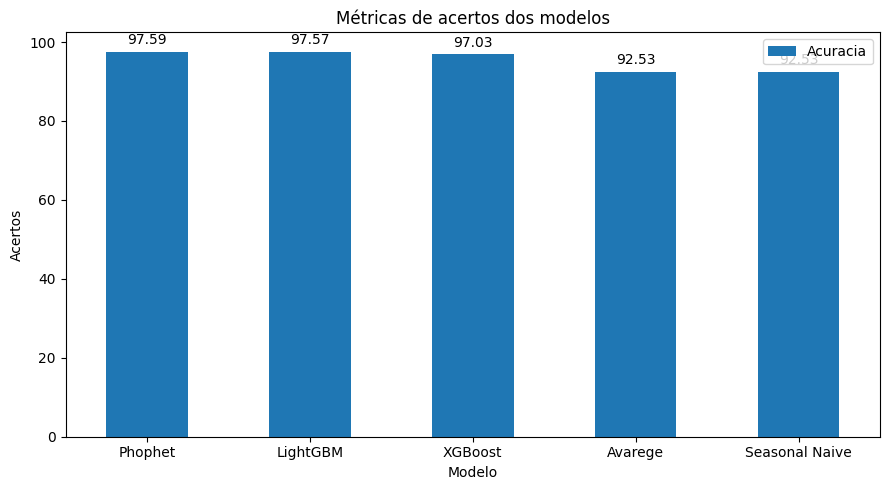

In [66]:
resultados['Acuracia'] = resultados['Acuracia']
ax = resultados.sort_values(by=['Acuracia'], ascending=False).plot(kind='bar', y=['Acuracia'], x='Modelo', figsize=(9,5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')
ax.set_title('Métricas de acertos dos modelos')
ax.set_ylabel('Acertos')
ax.bar_label(ax.containers[0], fmt='%.2f', padding=3)
ax.get_figure().set_tight_layout(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
plt.show()

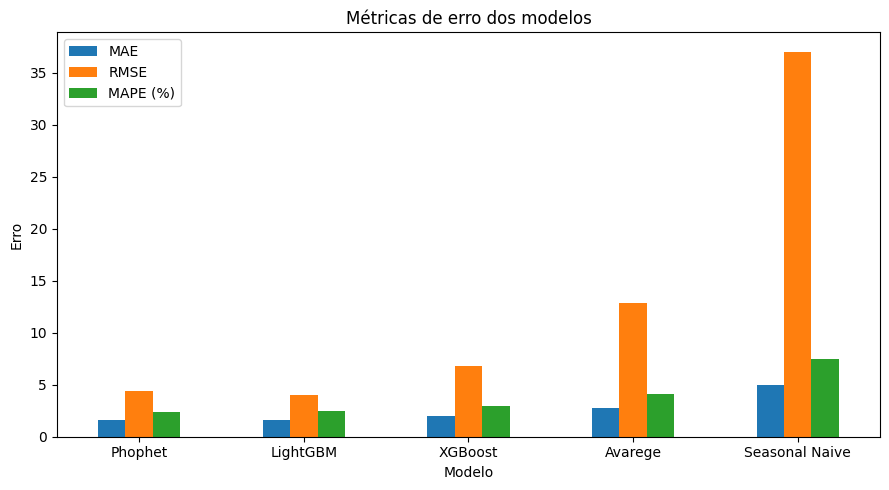

In [67]:
ax = resultados.sort_values(by=['Acuracia'], ascending=False).plot(kind='bar', y=['MAE', 'RMSE', 'MAPE (%)'], x='Modelo', figsize=(9,5))

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')
ax.set_title('Métricas de erro dos modelos')
ax.set_ylabel('Erro')
ax.get_figure().set_tight_layout(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
plt.show()

**Conclusão**

Embora o LightGBM tenha apresentado um desempenho superior em termos de RMSE (Raiz do Erro Quadrático Médio) — métrica que tende a penalizar mais os erros extremos —, nas demais métricas de avaliação o modelo Prophet demonstrou resultados mais consistentes.

O Prophet teve melhor desempenho em termos de MAPE (%) (Erro Percentual Absoluto Médio), MAE (Erro Absoluto Médio) e acurácia, indicando uma performance mais estável e precisa na média geral das previsões.

Diante disso, optamos por utilizar o Prophet como modelo final, considerando seu equilíbrio entre desempenho e interpretabilidade.

## **11. Salvando o Modelo**

Por fim, salvamos o modelo utilizando o Joblib para que ele possa ser carregado e utilizado no Streamlit.

In [68]:
joblib.dump(m, 'prophet_modelo.joblib')

['prophet_modelo.joblib']

In [69]:
train_prophet.to_csv('train_prophet.csv')